In [12]:
import re
import datetime
from math import log
import csv
import pprint
import math
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from elasticsearch import Elasticsearch, helpers

from __future__ import division

%matplotlib inline

pp = pprint.PrettyPrinter()

In [13]:
es = Elasticsearch([{'host': 'hcc-metrics.unl.edu', 'port': 9200}])

In [14]:
indices = es.cat.indices(index="cms-*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']

In [15]:
def time_filter(indices, days=0, until=0):
    if days == 0:
        return ["cms-*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'cms-', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if until <= diff.days < days + until:
            filtered.append(i.rstrip())
    return filtered

In [78]:
# Change second argument to use a different time range for ES queries
ind = time_filter(indices, 90, 270)
ind = ','.join(ind)

These variables are used:
* **RequestCpus**: number of cores used by the job
* **CpuTimeHr**: CPU time used by the job (hours)
* **WallClockHr**: wall-clock time used by the job (hours)
* **CoreHr**: wall-clock time used by the job times the number of cores (hours)
* **CpuEff**: CPU efficiency (%)
* **Type**: type of job (production or analysis)
* **Status**: job status (completed, running, idle, removed, held)
* **TaskType**: task type (analysis, production, merge, digireco, repack, reco, cleanup, logcollect, miniaod, express, dataprocessing, gensim, etc.)
* **Site**: site assigned to the job
* **WMAgent_RequestName**: request name
* **Kevents**: thousands of events in the job (often not reported by CMSSW!)

In [79]:
s2 = {
    "size": 0,
    "query": {
        "filtered": {
            "filter": {
                "bool": {
                    "must": [
                        {
                            "range": {
                                "RequestCpus": {"gte": 1}
                            }
                        },
                        {
                            "range": {
                                "CpuTimeHr": {"gt": 0.0001}
                            }
                        },
                        {
                            "range": {
                                "CoreHr": {"gt": 0.0001}
                            }
                        },
                        { 
                            "match": {
                                "Type":"production"
                            }
                        },
                        { 
                            "range": {
                                "KEvents": {"ge": 0.001}
                            }
                        },
                        {
                            "match": {
                                "Status": "completed"
                            }
                        }
                    ]
                }
            }
        }
    },
    "aggs": {
        "ptypes": {
            "terms": {
                "field": "TaskType",
                "size": 1000
            },
            "aggs": {
                "site": {
                    "terms": {
                        "field": "Site",
                        "size": 1000
                    },
                    "aggs": {
                        "jtask": {
                            "terms": {
                                "field": "WMAgent_RequestName",
                                "size": 100000
                            },
                            "aggs": {
                                "1": {
                                    "extended_stats": {
                                        "script": "doc['CpuTimeHr'].value / doc['KEvents'].value * 3.6",
                                        "lang": "expression"
                                    }
                                },
                                "2": {
                                    "extended_stats": {
                                        "script": "doc['CoreHr'].value / doc['KEvents'].value * 3.6",
                                        "lang": "expression"
                                    }
                                },
                                "3": {
                                    "sum": {
                                        "script": "(doc['CpuTimeHr'].value) * 3600",
                                        "lang": "expression"
                                    }
                                },
                                "4": {
                                    "sum": {
                                        "script": "(doc['CoreHr'].value) * 3600",
                                        "lang": "expression"
                                    }
                                },
                                "6": {
                                    "avg": {
                                        "field": "RequestCpus"
                                    }
                                },
                                "7": {
                                    "sum": {
                                        "script": "(doc['KEvents'].value) ? doc['KEvents'].value * 1000 : 0"
                                    }
                                },
                                "8": {
                                    "avg": {
                                        "field": "CpuEff"
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}

res = es.search(index=ind, body=s2, request_timeout=12000)

In [80]:
output_file = 'task_cms_90d_4.csv'

In [81]:
with open(output_file, 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    buckets1 = res['aggregations']['ptypes']['buckets']
    for b1 in buckets1:
        ptype = b1['key']
        buckets2 = b1['site']['buckets']
        for b2 in buckets2:
            site = b2['key']
            buckets3 = b2['jtask']['buckets']
            for b3 in buckets3:
                jtask = b3['key']
                writer.writerow([
                    jtask,
                    ptype,
                    site,
                    b3['1']['count'],           # no. of jobs in request
                    b3['1']['avg'],             # average of CPU time per event
                    b3['1']['std_deviation'],   # standard deviation of CPU time per event
                    b3['2']['avg'],             # average of wall-clock time times cores per event
                    b3['2']['std_deviation'],   # standard deviation of wall-clock time times cores per event
                    b3['3']['value'],           # total CPU time (seconds)
                    b3['4']['value'],           # total wall-clock time times cores (seconds)
                    b3['6']['value'],           # cores
                    b3['7']['value'],           # events (thousands)
                    b3['8']['value']            # CPU efficiency (%)
                    ])

In [66]:
#pp.pprint(res)

In [99]:
input_file = 'task_cms.csv'

In [100]:
df = pd.read_csv(input_file, dtype={'cpu_n': 'float'}, names=['request', 'processingtype', 'site',
                                                               'njobs', 'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg',
                                                               'wallevt_rms', 'cpu', 'wc', 'cores', 'evts', 'eff'])

In [101]:
df[:10]

,request,processingtype,site,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,wallevt_rms,cpu,wc,cores,evts,eff
0,anlevin_rvcmssw_8_0_0rundoubleegprpt2015c__rel...,hltdr2_25ns,t1_us_fnal,817,10.097794,7.939980,18.158900,15.722155,82252,144085,1,9410,58.143207
1,mewu_rvcmssw_8_0_1rundoubleegprpt2015c__relval...,hltdr2_25ns,t1_us_fnal,817,9.893302,6.682816,49.135057,41.418394,80562,383612,4,9410,20.521420
2,anlevin_rvcmssw_8_0_0runsinglemuprpt2015c__rel...,hltdr2_25ns,t1_us_fnal,816,6.473030,4.741631,9.376907,7.608326,84286,119847,1,14552,69.694853
3,mewu_rvcmssw_8_0_1runsinglemuprpt2015c__relval...,hltdr2_25ns,t1_us_fnal,816,7.823883,4.636523,35.288178,31.768490,102370,440876,4,14547,22.937500
4,heli_rvcmssw_8_0_1runsinglemuprpt2015c__gcc530...,hltdr2_25ns,t1_us_fnal,772,6.658261,3.763443,31.608104,26.213895,82900,372788,4,13677,22.163149
5,anlevin_rvcmssw_8_0_0runmet2015c__relval_met20...,hltdr2_25ns,t1_us_fnal,685,2.757228,0.930490,3.371370,1.357975,148846,179765,1,54959,81.770803
6,anlevin_rvcmssw_8_0_0runsingleph2015c__relval_...,hltdr2_25ns,t1_us_fnal,685,2.047522,0.448938,2.182134,0.488343,819379,868736,1,399296,93.418978
7,anlevin_rvcmssw_8_0_0runzerobias2015c__relval_...,hltdr2_25ns,t1_us_fnal,685,1.023896,0.416808,1.191156,0.582802,229179,264744,1,227168,85.769343
8,heli_rvcmssw_8_0_1rundoubleeg2015c__gcc530_rel...,hltdr2_25ns,t1_us_fnal,685,2.232826,0.666340,3.089032,3.043967,2865918,3815216,4,1277698,74.964233
9,heli_rvcmssw_8_0_1runjetht2015c__gcc530_relval...,hltdr2_25ns,t1_us_fnal,685,2.392674,0.374694,3.182424,0.687318,2891896,3801492,4,1198470,75.711497


In [103]:
# Define aggregation
grouped = df.groupby(['processingtype'], as_index=True)

# Define function to average a given quantity using another quantity as weight
def weighted_avg(group, a, w):
    return np.average(group[a], weights=group[w])

# Calculate Series with the CPU time per event weighted by wall-clock time
a = grouped.apply(weighted_avg,'wallevt_avg', 'wc')
print a

processingtype
addmonojet_d3md3_13                                       96.108916
alcacos_up15                                               0.094221
alcacosd                                                   0.053704
alcacosdrun2                                               0.378779
alcahal                                                    0.311486
alcaminup15                                                0.163556
alcaskim                                                   0.152301
alcattup15                                                99.193646
bdtomumu_13                                                0.134311
beamhalo_13                                                4.291597
bstojpsiphi_13                                             0.118320
bstomumu_13                                                0.109494
bstomumu_forsteam_13tev_tunecuetp8m1                       0.097437
bulkg_m1200_narrow_2l2q_lhe_13tev                          0.072600
bumixing_13                      

In [133]:
grouped = df.groupby(['processingtype'], as_index=False)
a = grouped.agg({'request': 'nunique', # ok!
                 'cpuevt_avg' : 'mean',   # wrong!
                 'wallevt_avg': 'mean',   # wrong!
                 'wc': 'sum',             # ok!
                 'cores': 'mean',         # wrong!
                 'njobs': 'sum',          # ok!
                 'evts': 'sum'})         # ok!
a.sort_values('wc', ascending=False)

,processingtype,wc,evts,request,cpuevt_avg,cores,wallevt_avg,njobs
19,digi,2.048348e+11,9382046904,12006,3.543900,1.007449,5.979567,12752300
219,reco,6.731026e+10,7347616278,8087,2.175635,1.009971,2.457137,11779201
43,digireco,5.280268e+10,4397768357,1573,5.896764,3.064955,8.801823,2627495
18,dataprocessing,2.508617e+10,2579561367,319,5.649222,4.000000,8.368204,711901
196,production,1.798605e+10,6194941666,103,1.247336,1.000000,2.256573,749758
180,miniaod,1.563556e+10,12821693788,16640,0.905127,1.004399,1.058034,1729739
162,merge,4.955481e+09,38033568543,24048,0.054711,1.000721,0.173574,2666468
136,gensim,3.279480e+09,2194148009,238,1.051744,1.000000,1.395797,222274
343,steptwoproc,2.469658e+09,214106833,40,0.308603,1.000000,0.367803,588695
230,recodr2_25nsrehlt,1.413177e+09,170790164,357,2.172131,3.787466,2.929185,217432


1308.5621613


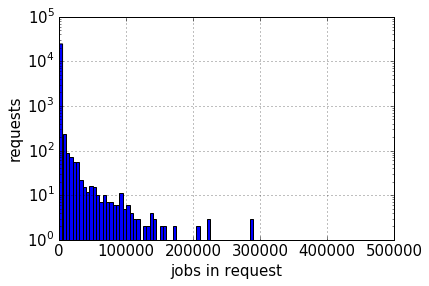

In [116]:
plt.rcParams.update({'font.size': 15})
grouped = df.groupby(['request'], as_index=False)
a = grouped['njobs'].sum()
print np.mean(a['njobs'])
fig = a['njobs'].hist(bins=100, log=True, range=[0., 500000.])
plt.xlabel('jobs in request')
plt.ylabel('requests')

230598.0


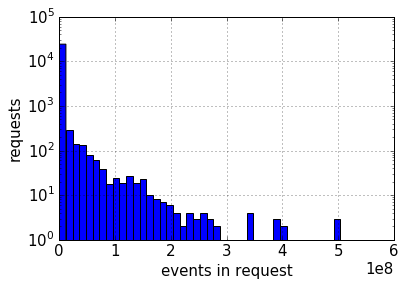

In [123]:
grouped = df.groupby(['request'], as_index=False)
a = grouped['evts'].sum()
print np.median(a['evts'])
fig = a['evts'].hist(bins=50, range=[0., 6e8], log=True)
plt.xlabel('events in request')
plt.ylabel('requests')

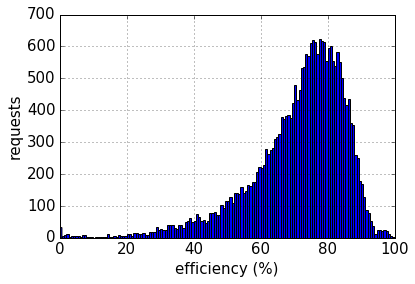

In [125]:
grouped = df.groupby(['request'], as_index=False)
a = grouped['eff'].mean()
fig = a['eff'].hist(bins=150, log=False, range=(0, 100))   # NOT VERY CORRECT (arithmetic mean of efficiencies...)
plt.xlabel('efficiency (%)')
plt.ylabel('requests')

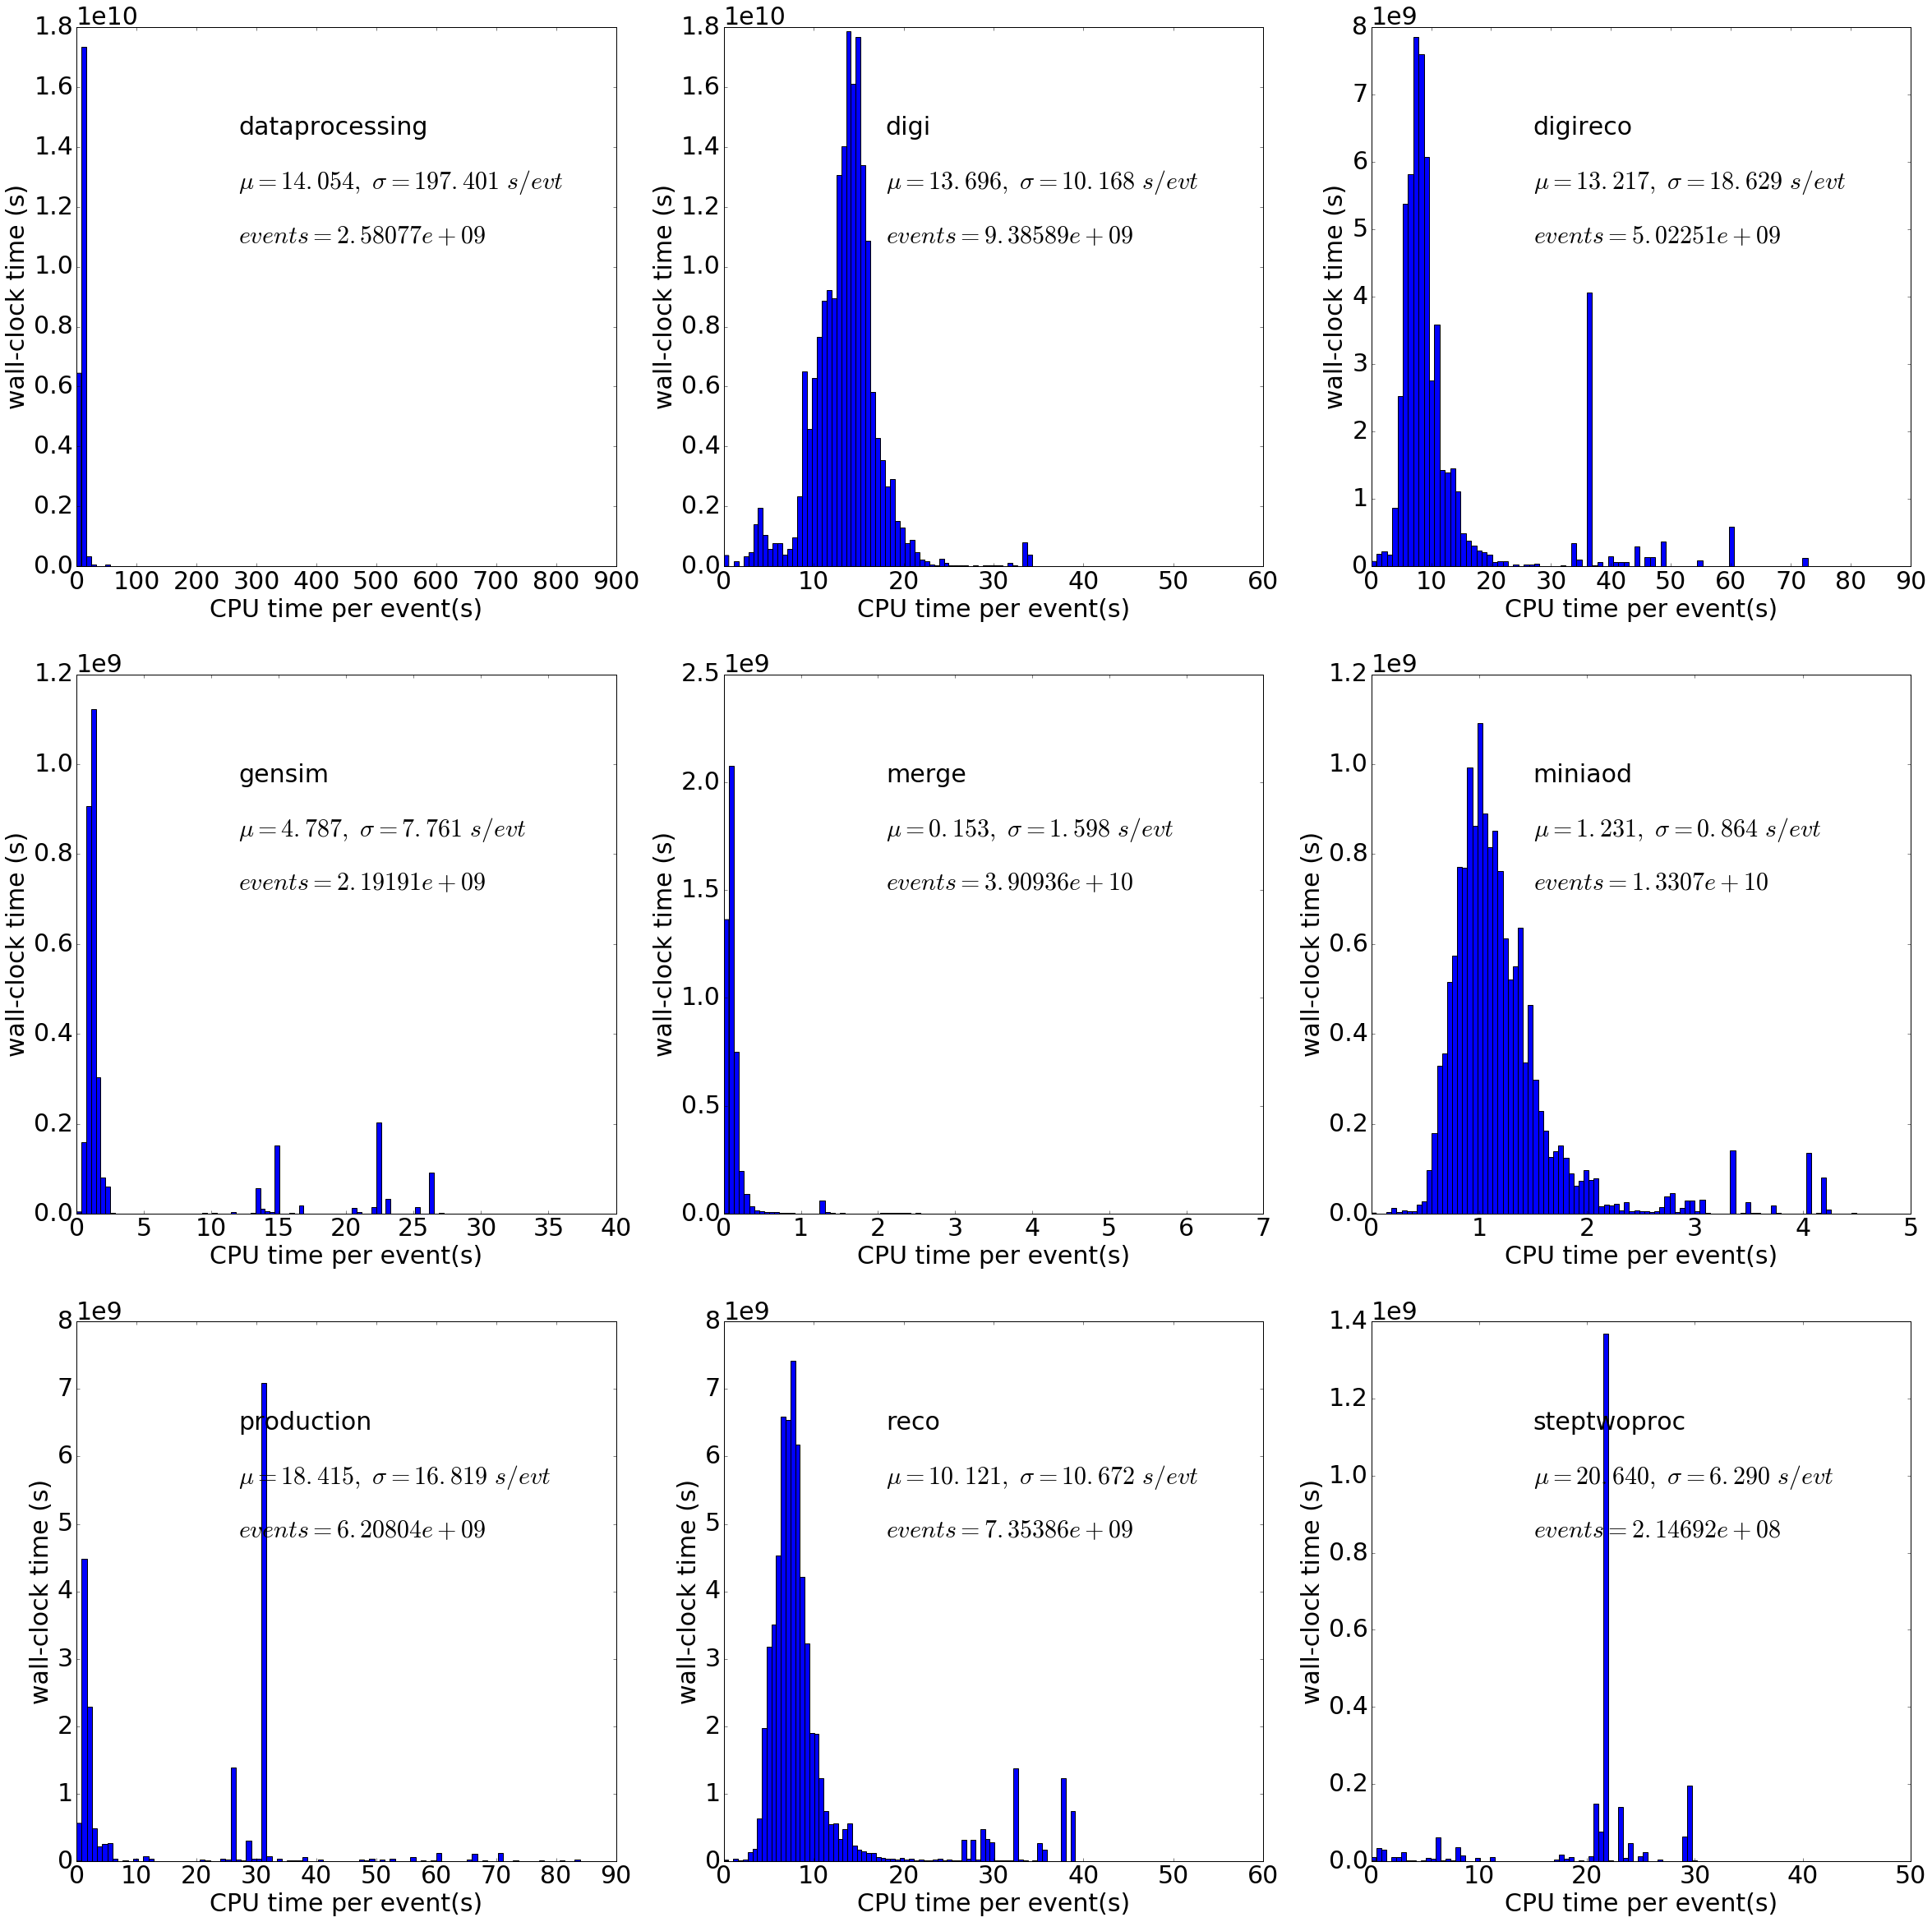

In [131]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'cpuevt_avg'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.005 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., mean + std * 4.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('CPU time per event(s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f\ s/evt$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['evts'].sum()
    if log_scale:
        plt.text(t_x(.3), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.3), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.3), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.3), t_y(.8), p)
        plt.text(t_x(.3), t_y(.7), stats)
        plt.text(t_x(.3), t_y(.6), stats2)
    i += 1

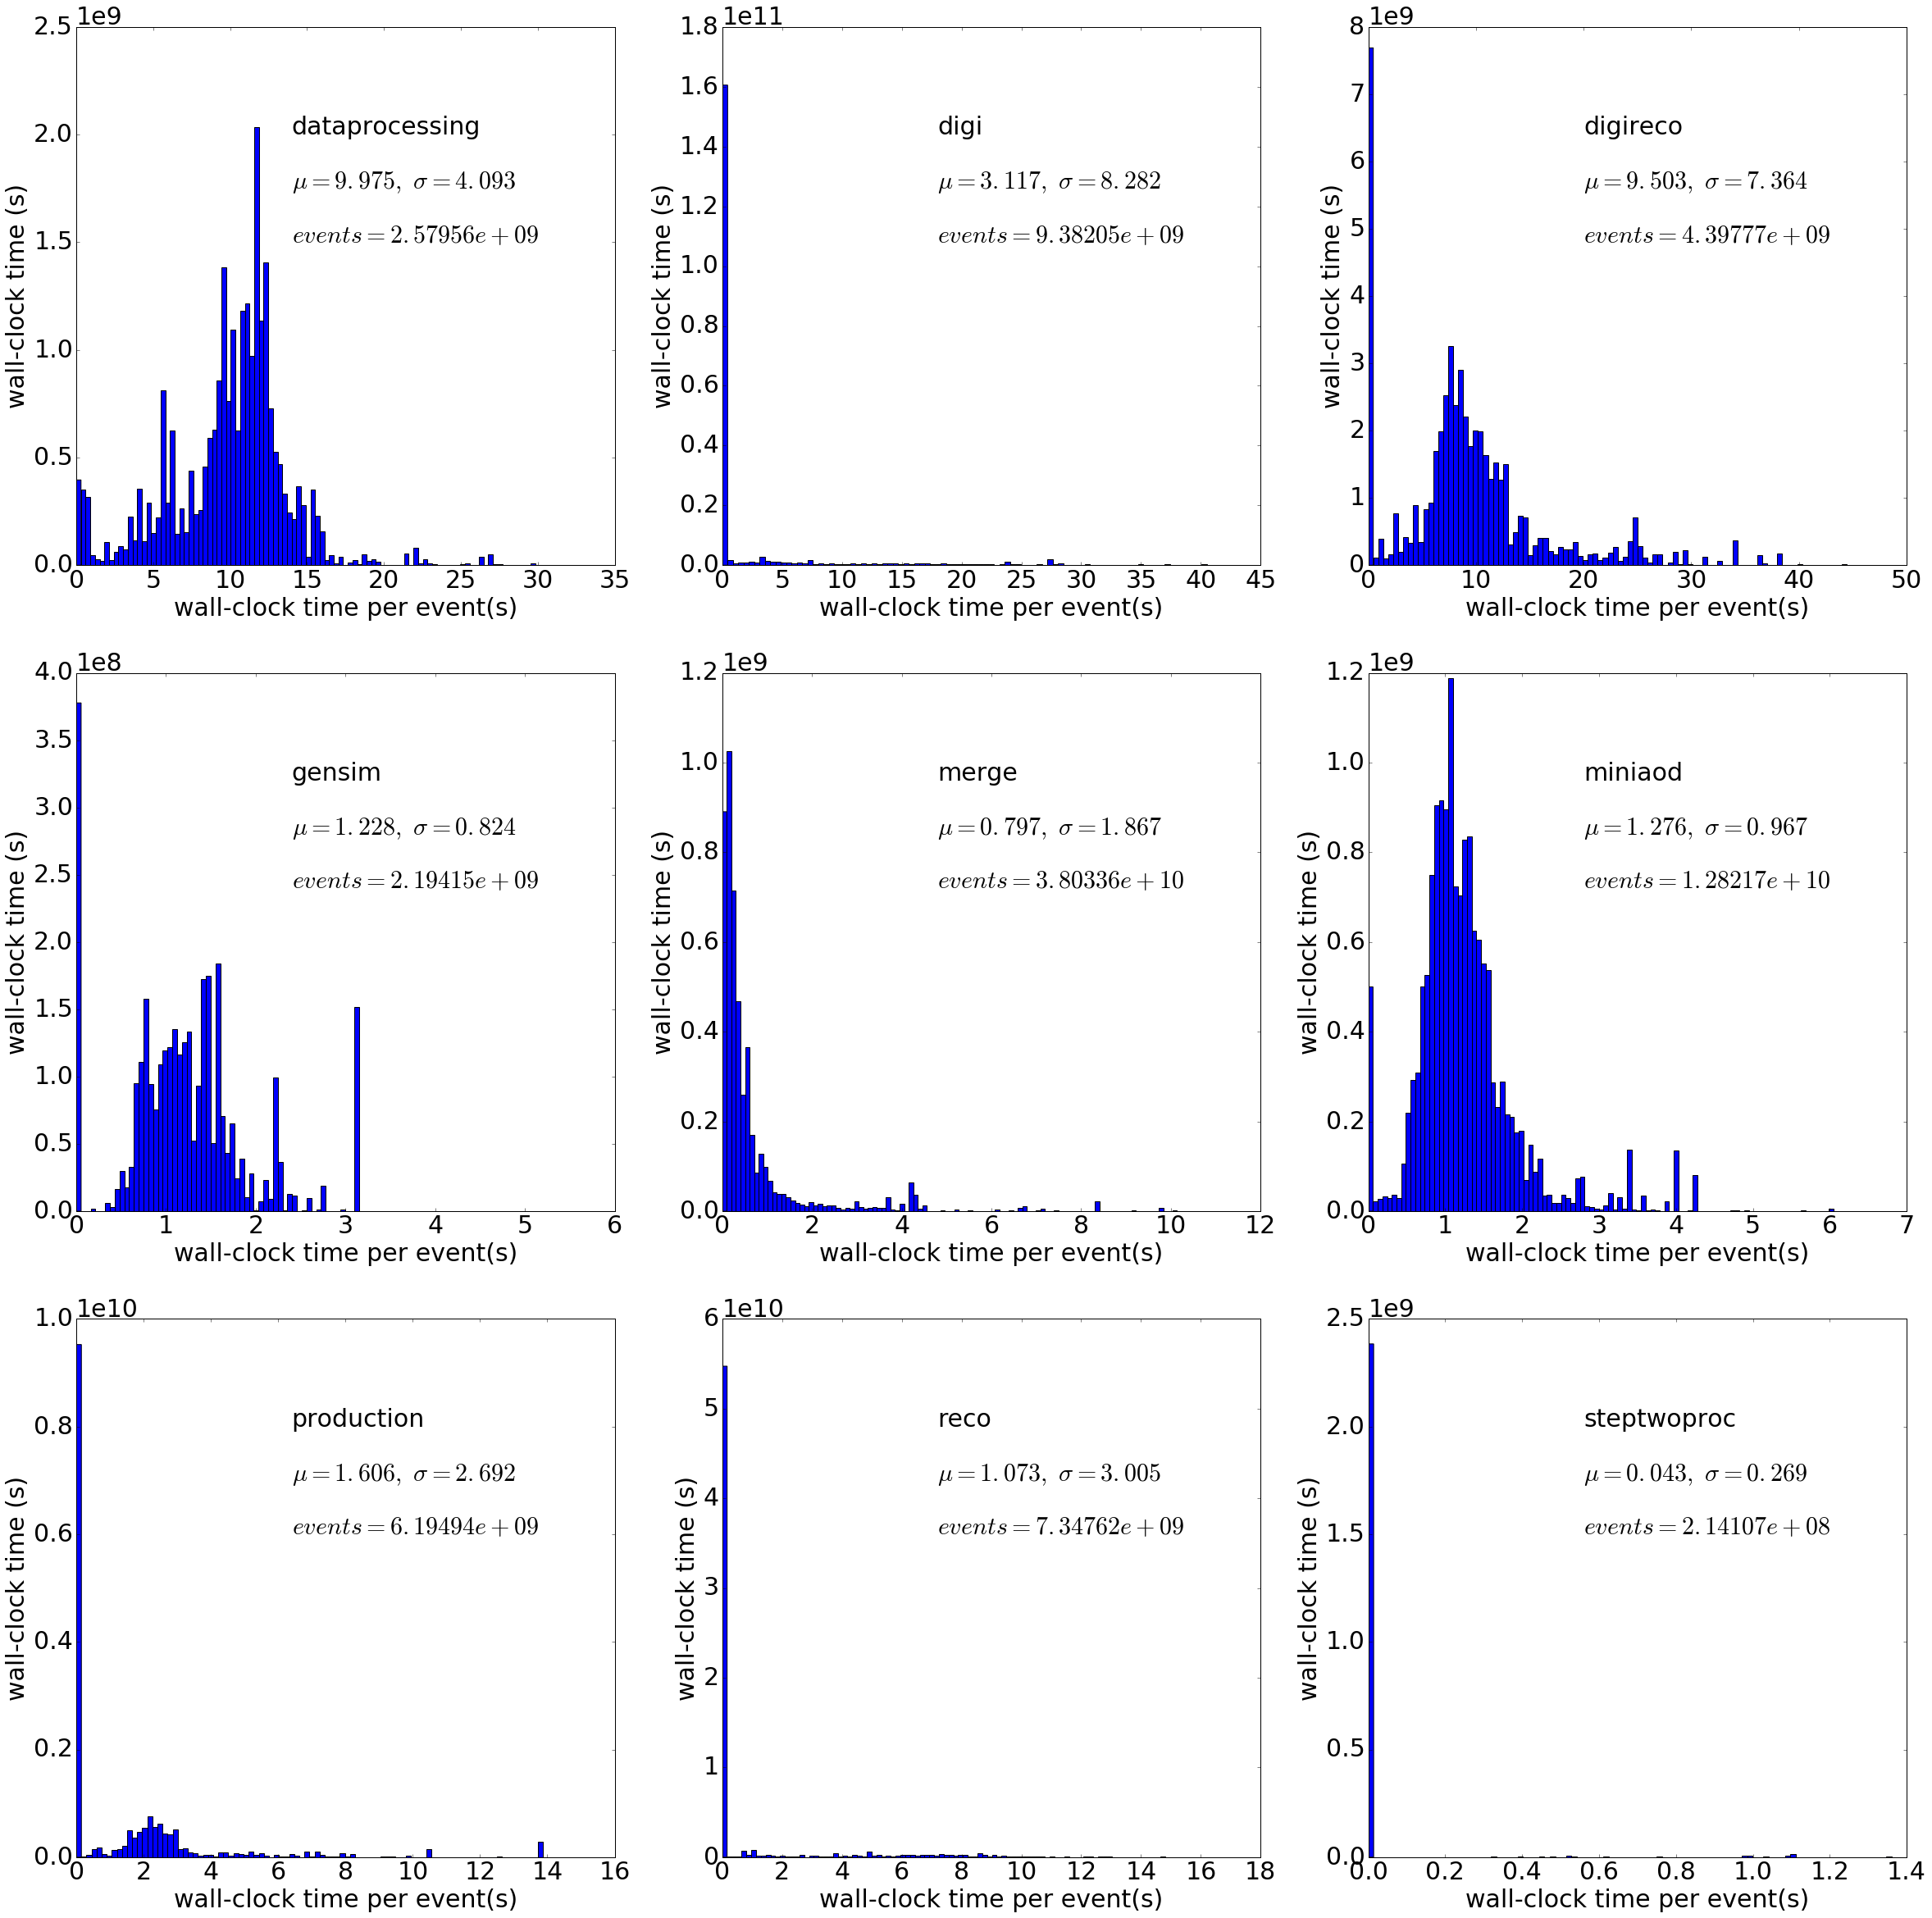

In [138]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'wallevt_avg'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.005 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., min(mean + std * 5., 8000.)]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('wall-clock time per event(s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['evts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.4), t_y(.8), p)
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.6), stats2)
    i += 1